In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
from plotly.offline import iplot
import matplotlib.pyplot as plt
import matplotlib as mpl


import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import scipy.stats as scs

from functions.make_df_without_gaps import make_df_without_gaps
import warnings 
warnings.simplefilter('ignore')
import pickle

with open('../name_wells_pickle/dict_name_well.pickle', 'rb') as f:
    dict_name_well = pickle.load(f)
with open('../name_wells_pickle/dict_name_well_oil_more_365.pickle', 'rb') as f:
    dict_name_oil_well_year = pickle.load(f)

%config InlineBackend.figure_formats = 'svg'

from functions.make_df_with_count_days_ago import make_df_with_count_days_ago
from functions.uppend_p_zab import uppend_p_zab
from functions.uppend_inj_wells import uppend_inj_wells
from functions.stationary import tsplot, tsplot_rus_labels, make_stationary, un_stationary, unboxcox, unyeo_johnson
from functions.code_with_mean import code_with_mean
from functions.uppend_mean_target_for_weekday_day import uppend_mean_target_for_weekday_day
%matplotlib inline

plt.rcParams['font.family'] = 'Times New Roman'

mpl.rcParams.update({'font.size': 11})

In [44]:
train = pd.read_csv('../../data/basic_data/train_data.csv')
train['WELL_NAME'] = train['WELL_NAME'].map(dict_name_well)
train.drop(columns=['KCHARWORK', 'MEASURED_IN', 'IS_WORKING'], inplace=True)
train['MEASURED_IN_DATE'] = pd.to_datetime(train['MEASURED_IN_DATE'])

coord_well = pd.read_csv('../../data/basic_data/coords.csv')
coord_well['WELL_NAME'] = coord_well['WELL_NAME'].map(dict_name_well)
coord_well.dropna(inplace=True)
coord_well = coord_well.set_index('WELL_NAME')
coord_well.sort_index(inplace=True);


train_oil_year_accum = pd.read_csv('../../data/preprocessed_data/train_oil_year_accum.csv')
train_oil_year_accum['MEASURED_IN_DATE'] = pd.to_datetime(train_oil_year_accum['MEASURED_IN_DATE'])
train_oil_year_accum.drop(columns=['INTAKE', 'WELLHEAD_PRESSURE'], inplace=True)

In [45]:
train_oil_year_accum

,MEASURED_IN_DATE,WELL_NAME,CHARWORK,WATER_CUT,P_ZAB,LIQ_RATE,OIL_RATE,WATER_RATE,Q_LIQ_ACCUM,Q_OIL_ACCUM,Q_WATER_ACCUM
0,2020-01-17,1,НЕФ,26.0,59.20,221.0,163.54,57.46,221.0,163.54,57.46
1,2020-01-18,1,НЕФ,26.0,59.20,221.0,163.54,57.46,442.0,327.08,114.92
2,2020-01-19,1,НЕФ,26.0,59.20,221.0,163.54,57.46,663.0,490.62,172.38
3,2020-01-20,1,НЕФ,26.0,59.20,221.0,163.54,57.46,884.0,654.16,229.84
4,2020-01-21,1,НЕФ,30.0,59.26,208.0,145.60,62.40,1092.0,799.76,292.24
...,...,...,...,...,...,...,...,...,...,...,...
105024,2022-05-27,258,НЕФ,92.0,49.60,237.0,18.96,218.04,115663.0,60264.69,55398.31
105025,2022-05-28,258,НЕФ,92.0,49.60,237.0,18.96,218.04,115900.0,60283.65,55616.35
105026,2022-05-29,258,НЕФ,92.0,49.60,237.0,18.96,218.04,116137.0,60302.61,55834.39
105027,2022-05-30,258,НЕФ,92.0,49.60,237.0,18.96,218.04,116374.0,60321.57,56052.43


In [5]:
graph_wells = pd.DataFrame(index=range(266))
for well in range(266):
    graph_wells[well] = np.sqrt(np.square(coord_well['COORD_X'] - coord_well[coord_well.index == well]['COORD_X'].values) +
                        np.square(coord_well['COORD_Y'] - coord_well[coord_well.index == well]['COORD_Y'].values))
graph_wells

,0,1,2,3,4,5,6,7,8,9,...,256,257,258,259,260,261,262,263,264,265
0,0.000000,5550.282189,1208.834563,7466.414534,2316.878288,1197.448120,2112.274603,1706.095479,1879.414649,4742.804655,...,4751.633818,3902.751253,1703.789632,1836.696196,1650.054443,2666.949595,7000.858697,4118.238649,7388.558098,7740.414535
1,5550.282189,0.000000,6215.509514,12069.082204,7866.817142,6741.650306,7635.158454,6554.488347,7273.234877,10121.601743,...,829.080852,1788.555145,5775.980221,5916.349271,4472.687248,6694.739180,7255.699064,6868.956089,9719.150350,9519.010449
2,1208.834563,6215.509514,0.000000,6321.573934,2017.786906,1116.962399,2095.214786,497.772202,1117.914273,3906.176775,...,5470.104568,4728.386126,879.996245,2942.017191,1792.375581,1530.075606,6270.660809,3117.241943,6283.835818,6701.673134
3,7466.414534,12069.082204,6321.573934,0.000000,5995.745575,6566.353630,6502.122269,5848.268857,5700.068596,3645.387497,...,11447.148605,10870.636613,6414.923193,8805.689219,7732.730321,5393.659576,7884.938204,5492.007312,4977.398349,5894.226812
4,2316.878288,7866.817142,2017.786906,5995.745575,0.000000,1129.559649,506.557993,2068.559954,1035.284290,2681.284207,...,7068.105652,6207.498601,2872.923750,2927.751109,3691.727659,3058.434436,8068.295918,4709.569222,7448.348587,8036.912300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,2666.949595,6694.739180,1530.075606,5393.659576,3058.434436,2525.443316,3325.231418,1124.461861,2028.705494,3909.063369,...,6054.852165,5491.975310,1103.793531,4462.378418,2361.695532,0.000000,5014.708982,1666.872592,4753.812242,5185.524384
262,7000.858697,7255.699064,6270.660809,7884.938204,8068.295918,7384.430380,8297.323963,6038.820084,7033.959670,8418.622345,...,7144.936223,7279.170404,5423.616473,8764.867660,5583.159517,5014.708982,0.000000,3420.000761,3357.410401,2709.276767
263,4118.238649,6868.956089,3117.241943,5492.007312,4709.569222,4174.317558,4991.394844,2773.973523,3688.100107,5090.510211,...,6382.391423,6048.139485,2414.494156,5954.448298,3223.209031,1666.872592,3420.000761,0.000000,3340.444385,3622.757215
264,7388.558098,9719.150350,6283.835818,4977.398349,7448.348587,7220.132193,7842.414172,5854.298413,6541.552184,6699.068826,...,9377.966279,9201.865824,5703.162238,9208.458661,6554.294815,4753.812242,3357.410401,3340.444385,0.000000,916.869575


In [48]:
df = make_df_without_gaps(train_oil_year_accum, date_column='MEASURED_IN_DATE', group_params='WELL_NAME')
df = make_df_with_count_days_ago(dataframe=df, count_days=5, target='OIL_RATE')
df = uppend_p_zab(preproc_df=df, train_df=train_oil_year_accum)
df = uppend_inj_wells(preproc_df=df, train_df=train, distance=True, graph_wells=graph_wells)
df = uppend_mean_target_for_weekday_day(df, 'TARGET_OIL_RATE')

In [29]:
new_columns = ['Номер_скважины'] + \
                [f'Дебит по нефти {i} дней назад' for i in range(5, 4, -1)] + \
                [f'Дебит по нефти {i} дня назад' for i in range(4, 1, -1)] + ['Дебит по нефти 1 день назад'] + \
                ['Предсказываемый дебит по нефти']
df.columns = new_columns

In [31]:
df

,Номер_скважины,Дебит по нефти 5 дней назад,Дебит по нефти 4 дня назад,Дебит по нефти 3 дня назад,Дебит по нефти 2 дня назад,Дебит по нефти 1 день назад,Предсказываемый дебит по нефти
MEASURED_IN_DATE,,,,,,,
2020-09-05,1,98.80,97.60,99.63,96.40,91.20,90.82
2020-09-06,1,97.60,99.63,96.40,91.20,90.82,92.82
2020-09-07,1,99.63,96.40,91.20,90.82,92.82,96.76
2020-09-08,1,96.40,91.20,90.82,92.82,96.76,96.76
2020-09-09,1,91.20,90.82,92.82,96.76,96.76,95.94
...,...,...,...,...,...,...,...
2021-09-20,258,99.36,99.82,100.28,101.20,100.74,99.82
2021-09-21,258,99.82,100.28,101.20,100.74,99.82,101.66
2021-09-22,258,100.28,101.20,100.74,99.82,101.66,100.28


In [18]:
train_oil_year_accum.columns = ['Дата_замера', 'Номер_скважины',
                                     'Тип скважины', 'Обводненность',
                                     'Pзаб', 'Дебит по жидкости',
                                     'Дебит по нефти', 'Дебит по воде',
                                     "Накопленная добыча жидкости", "Накопленная добыча нефти",
                                     "Накопленная добыча воды"]
train_oil_year_accum

,Дата_замера,Номер_скважины,Тип скважины,Обводненность,Pзаб,Дебит по жидкости,Дебит по нефти,Дебит по воде,Накопленная добыча жидкости,Накопленная добыча нефти,Накопленная добыча воды
0,2020-01-17,1,НЕФ,26.0,59.20,221.0,163.54,57.46,221.0,163.54,57.46
1,2020-01-18,1,НЕФ,26.0,59.20,221.0,163.54,57.46,442.0,327.08,114.92
2,2020-01-19,1,НЕФ,26.0,59.20,221.0,163.54,57.46,663.0,490.62,172.38
3,2020-01-20,1,НЕФ,26.0,59.20,221.0,163.54,57.46,884.0,654.16,229.84
4,2020-01-21,1,НЕФ,30.0,59.26,208.0,145.60,62.40,1092.0,799.76,292.24
...,...,...,...,...,...,...,...,...,...,...,...
105024,2022-05-27,258,НЕФ,92.0,49.60,237.0,18.96,218.04,115663.0,60264.69,55398.31
105025,2022-05-28,258,НЕФ,92.0,49.60,237.0,18.96,218.04,115900.0,60283.65,55616.35
105026,2022-05-29,258,НЕФ,92.0,49.60,237.0,18.96,218.04,116137.0,60302.61,55834.39
105027,2022-05-30,258,НЕФ,92.0,49.60,237.0,18.96,218.04,116374.0,60321.57,56052.43


train_oil_year_accum_stationary.reset_index(inplace=True, drop=True)
train_oil_year_accum_stationary.dropna(inplace=True)
train_oil_year_accum_stationary.to_csv('../../data/preprocessed_data/train_oil_year_accum_stationary.csv', index_label=False)

In [205]:

df = make_df_without_gaps(train_oil_year_accum_stationary, date_column='MEASURED_IN_DATE', group_params='WELL_NAME')
df = make_df_with_count_days_ago(dataframe=df, count_days=50, target='OIL_RATE')
df = uppend_p_zab(preproc_df=df, train_df=train_oil_year_accum_stationary)
if 'MEASURED_IN_DATE' in df.columns:
    df.set_index('MEASURED_IN_DATE', inplace=True)
df

,P_ZAB,WELL_NAME,OIL_RATE_50_days_ago,OIL_RATE_49_days_ago,OIL_RATE_48_days_ago,OIL_RATE_47_days_ago,OIL_RATE_46_days_ago,OIL_RATE_45_days_ago,OIL_RATE_44_days_ago,OIL_RATE_43_days_ago,...,OIL_RATE_9_days_ago,OIL_RATE_8_days_ago,OIL_RATE_7_days_ago,OIL_RATE_6_days_ago,OIL_RATE_5_days_ago,OIL_RATE_4_days_ago,OIL_RATE_3_days_ago,OIL_RATE_2_days_ago,OIL_RATE_1_days_ago,TARGET_OIL_RATE
MEASURED_IN_DATE,,,,,,,,,,,,,,,,,,,,,
2020-10-20,-5.622725e-12,1,0.004225,-0.006649,0.003531,-0.004944,-0.014805,-0.000022,0.004555,0.002282,...,-0.021650,0.001911,-0.005515,0.000889,0.000985,0.000000,-0.001069,0.025395,-0.001077,0.006480
2020-10-21,-1.134266e-10,1,-0.006649,0.003531,-0.004944,-0.014805,-0.000022,0.004555,0.002282,0.002099,...,0.001911,-0.005515,0.000889,0.000985,0.000000,-0.001069,0.025395,-0.001077,0.006480,0.001062
2020-10-22,0.000000e+00,1,0.003531,-0.004944,-0.014805,-0.000022,0.004555,0.002282,0.002099,-0.005004,...,-0.005515,0.000889,0.000985,0.000000,-0.001069,0.025395,-0.001077,0.006480,0.001062,0.000000
2020-10-23,0.000000e+00,1,-0.004944,-0.014805,-0.000022,0.004555,0.002282,0.002099,-0.005004,0.003425,...,0.000889,0.000985,0.000000,-0.001069,0.025395,-0.001077,0.006480,0.001062,0.000000,0.000000
2020-10-24,0.000000e+00,1,-0.014805,-0.000022,0.004555,0.002282,0.002099,-0.005004,0.003425,0.005371,...,0.000985,0.000000,-0.001069,0.025395,-0.001077,0.006480,0.001062,0.000000,0.000000,0.001069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-20,0.000000e+00,258,-0.008786,0.025211,0.041541,0.053405,-0.008942,0.031312,0.047241,0.009201,...,-0.026160,0.018394,-0.013638,0.018015,0.018309,0.004525,0.013701,0.013577,-0.022857,0.000167
2021-09-21,-9.299113e-03,258,0.025211,0.041541,0.053405,-0.008942,0.031312,0.047241,0.009201,0.010589,...,0.018394,-0.013638,0.018015,0.018309,0.004525,0.013701,0.013577,-0.022857,0.000167,0.022503
2021-09-22,-3.043984e-03,258,0.041541,0.053405,-0.008942,0.031312,0.047241,0.009201,0.010589,-0.037033,...,-0.013638,0.018015,0.018309,0.004525,0.013701,0.013577,-0.022857,0.000167,0.022503,-0.031698


In [260]:
path_to_folder = '../../data/data_for_model/dataframes/'
name_files = os.listdir(path_to_folder)[1:]
name_files = [name for name in name_files if 'inj' not in name]

for i in range(len(name_files)):
    print(name_files[i][:-4])
    df = pd.read_csv(f'{path_to_folder}{name_files[i]}')
    df['MEASURED_IN_DATE'] = pd.to_datetime(df['MEASURED_IN_DATE'])
    df = uppend_inj_wells(preproc_df=df, train_df=train_inj_stationary.dropna(), distance=True, graph_wells=graph_wells)
    df.to_csv(f'../../data/data_for_model/dataframes/{name_files[i][:-4]}_inj_stat.csv')

20_days_ago_not_stat
20_days_ago_not_stat_P_ZAB_not_stat
20_days_ago_not_stat_P_ZAB_stat
20_days_ago_stat
20_days_ago_stat_P_ZAB_not_stat
20_days_ago_stat_P_ZAB_stat
50_days_ago_not_stat
50_days_ago_not_stat_P_ZAB_not_stat
50_days_ago_not_stat_P_ZAB_stat
50_days_ago_stat
50_days_ago_stat_P_ZAB_not_stat
50_days_ago_stat_P_ZAB_stat
5_days_ago_not_stat
5_days_ago_not_stat_P_ZAB_not_stat
5_days_ago_not_stat_P_ZAB_stat
5_days_ago_stat
5_days_ago_stat_P_ZAB_not_stat
5_days_ago_stat_P_ZAB_stat


In [ ]:
data = df[df['WELL_NAME'] == 1]['TARGET_OIL_RATE'].dropna()
tsplot(data, lags=30)

In [69]:
wells = train[train['CHARWORK'] == 'НАГ']['WELL_NAME'].unique()
numeric_columns = ['INTAKE'] #train.drop(columns=['WELL_NAME']).select_dtypes(include='number').columns.to_list()

train_inj_stationary = pd.DataFrame(columns=train.columns)
unstationary_data = pd.DataFrame(columns=['WELL_NAME'] + numeric_columns, index=wells)

for well in wells:
    
    data = train[train['WELL_NAME'] == well]
    data.reset_index(inplace=True, drop=True)
    for column in numeric_columns:
        data[column], lmbda_yj, n_season_value, n_season_values = make_stationary(data[column], n_season=7)
        unstationary_data.loc[well, column] = (lmbda_yj, n_season_value, n_season_values)
    train_inj_stationary = pd.concat([train_inj_stationary, data])

train_inj_stationary = pd.concat([train[~train['WELL_NAME'].isin(wells)], train_inj_stationary])

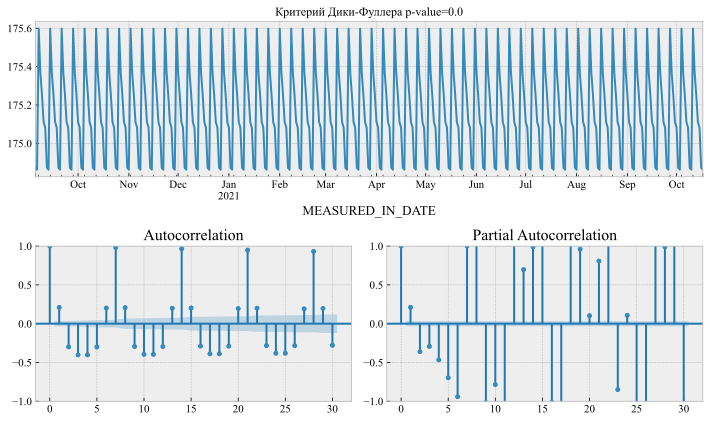

In [37]:
tsplot(df[df['WELL_NAME'] == 1]['WEEKDAY_AVERAGE'], lags=30)

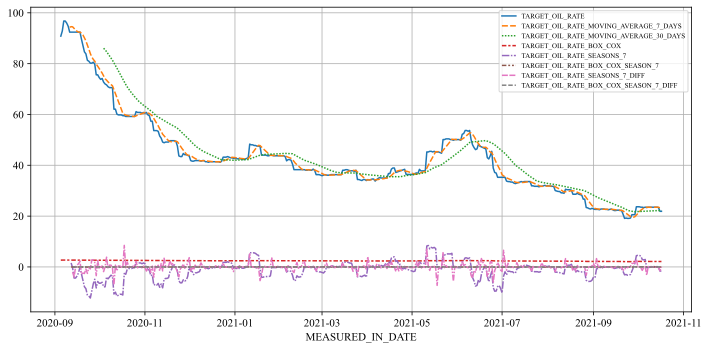

In [50]:

data = df[df['WELL_NAME'] == 1][['TARGET_OIL_RATE']]

data['TARGET_OIL_RATE_MOVING_AVERAGE_7_DAYS'] = data['TARGET_OIL_RATE'].rolling(window=7).mean()
data['TARGET_OIL_RATE_MOVING_AVERAGE_30_DAYS'] = data['TARGET_OIL_RATE'].rolling(window=30).mean()


data['TARGET_OIL_RATE_EXPON_SMOOTHING'] = exponetial_smoothing(data=data['TARGET_OIL_RATE'], 
                                                               alpha=0.05)
data['TARGET_OIL_RATE_DOUBLE_EXPON_SMOOTHING'] = double_exponential_smoothing(data=data["TARGET_OIL_RATE"], 
                                                                              alpha=0.1, 
                                                                              beta=0.5)
model = Holt_Winters(data=data['TARGET_OIL_RATE'],
                     slen=30,
                     alpha=0.9,
                     beta=0.6,
                     gamma=0.6,
                     n_preds=0, 
                     scaling_factor=1.98)
model.triple_exponential_smoothing()

data['TARGET_OIL_RATE_TRIPLE_EXPON_SMOOTHING'] = model.result



data['TARGET_OIL_RATE_BOX_COX'], lmbda = scs.boxcox(data['TARGET_OIL_RATE'])



data['TARGET_OIL_RATE_SEASONS_7'] = data['TARGET_OIL_RATE'] - data['TARGET_OIL_RATE'].shift(7)
data['TARGET_OIL_RATE_BOX_COX_SEASON_7'] = data['TARGET_OIL_RATE_BOX_COX'] - data['TARGET_OIL_RATE_BOX_COX'].shift(7)

data['TARGET_OIL_RATE_SEASONS_30'] = data['TARGET_OIL_RATE'] - data['TARGET_OIL_RATE'].shift(30)
data['TARGET_OIL_RATE_BOX_COX_SEASON_30'] = data['TARGET_OIL_RATE_BOX_COX'] - data['TARGET_OIL_RATE_BOX_COX'].shift(30)

data['TARGET_OIL_RATE_SEASONS_7_DIFF'] = data['TARGET_OIL_RATE_SEASONS_7'] - data['TARGET_OIL_RATE_SEASONS_7'].shift(1)
data['TARGET_OIL_RATE_BOX_COX_SEASON_7_DIFF'] = (data['TARGET_OIL_RATE_BOX_COX_SEASON_7'] 
                                        - data['TARGET_OIL_RATE_BOX_COX_SEASON_7'].shift(1))


plt.figure(figsize=(10, 5));
plt.grid(True)
sns.lineplot(data);
plt.legend(fontsize=7);
plt.tight_layout()

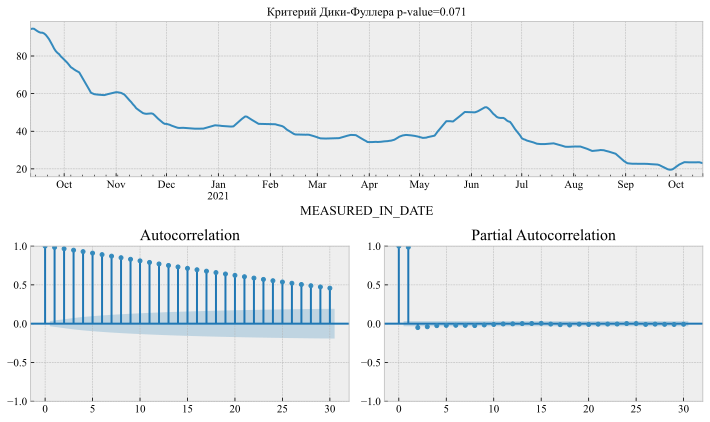

In [31]:
tsplot(data['TARGET_OIL_RATE_MOVING_AVERAGE_7_DAYS'].dropna(), lags=30)

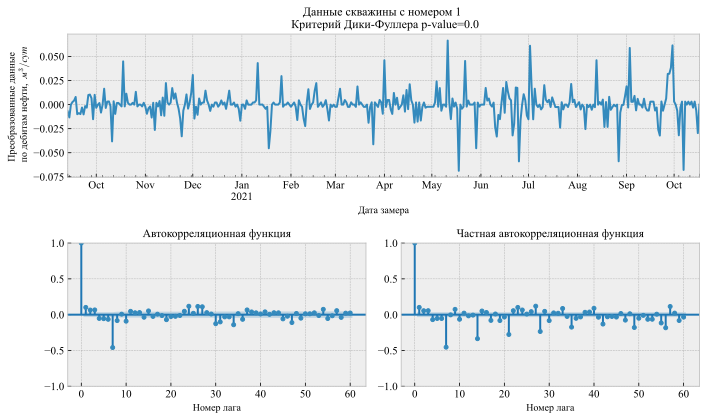

In [110]:
data['TARGET_OIL_RATE_BOX_COX_SEASON_7_DIFF'].index.name = 'Дата замера'
data['TARGET_OIL_RATE_BOX_COX_SEASON_7']
tsplot(data['TARGET_OIL_RATE_BOX_COX_SEASON_7_DIFF'].dropna(), lags=60)

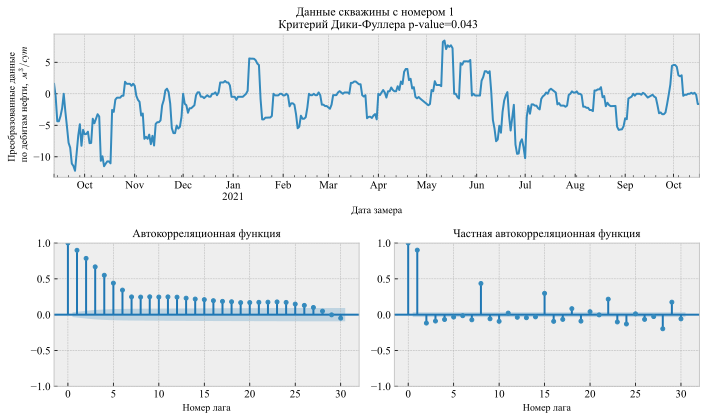

In [105]:
tsplot(data['TARGET_OIL_RATE_SEASONS_7'].dropna(), lags=30)

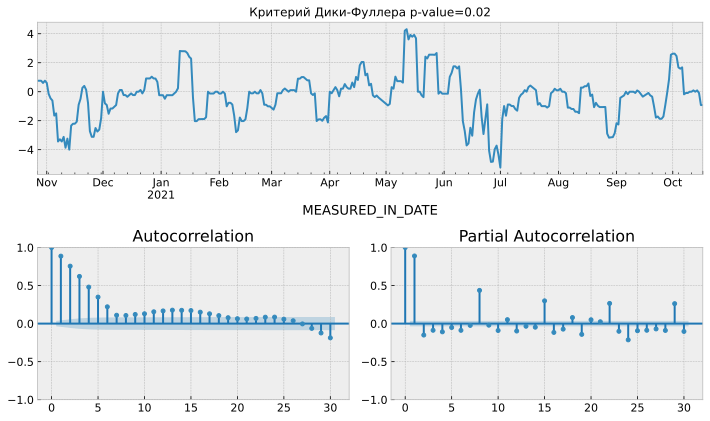

In [178]:
tsplot(data['TARGET_OIL_RATE_BOX_COX_SEASON_7'].dropna(), lags=30)

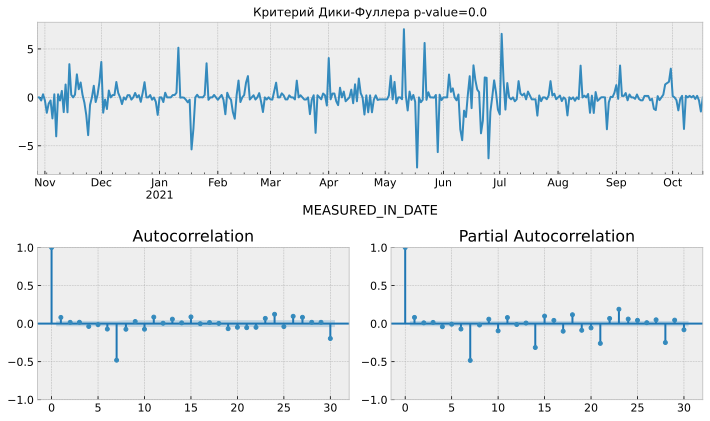

In [179]:
tsplot(data['TARGET_OIL_RATE_SEASONS_7_DIFF'].dropna(), lags=30)

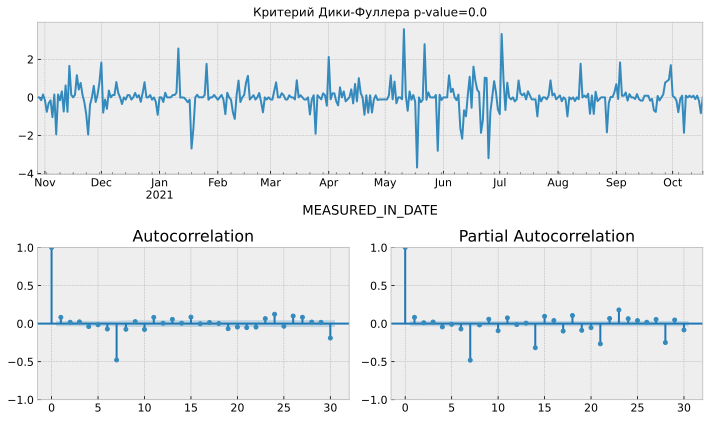

In [180]:
tsplot(data['TARGET_OIL_RATE_BOX_COX_SEASON_7_DIFF'].dropna(), lags=30)

In [120]:
result_lr = pd.read_csv('../../data/data_for_model/linear_regression/result_new.csv')
result_lr.drop(columns=['Unnamed: 0'], inplace=True)
result_lr.dropna().groupby(['DATAFRAME_NAME', 
                    'POLY_DEGREE', 
                    'DAY_AGO', 
                    'PREDICT_DAYS', 
                    'FEATURE_DEGREE']).sum().dropna().sort_values(by=['MSE', 'MAE'])

WELL_NAME   
DATAFRAME_NAME                                     POLY_DEGREE DAY_AGO PREDICT_DAYS FEATURE_DEGREE                         
50_days_ago_stat_P_ZAB_stat_inj_stat.csv           7           50      45           OIL_RATE_1_days_ago P_ZAB        125  \
                                                   5           50      60           OIL_RATE_1_days_ago P_ZAB        125   
                                                   6           50      120          OIL_RATE_1_days_ago P_ZAB        125   
                                                   7           50      60           OIL_RATE_1_days_ago P_ZAB        125   
                                                                       120          OIL_RATE_1_days_ago P_ZAB        125   
...                                                                                                                  ...   
50_days_ago_not_stat_P_ZAB_not_stat_inj_not_sta... 4           50      45           P_ZAB                          18097   
                                                                       30           P_ZAB                          18097   
                                                   5           50      60           P_ZAB                          18097   
                                                                       45           P_ZAB                          18097   
                                                                       30           P_ZAB                          18097   

                                                                                                                        MSE   
DATAFRAME_NAME                                     POLY_DEGREE DAY_AGO PREDICT_DAYS FEATURE_DEGREE                            
50_days_ago_stat_P_ZAB_stat_inj_stat.csv           7           50      45           OIL_RATE_1_days_ago P_ZAB  1.483222e+00  \
                                                   5           50      60           OIL_RATE_1_days_ago P_ZAB  1.821480e+00   
                                                   6           50      120          OIL_RATE_1_days_ago P_ZAB  1.861124e+00   
                                                   7           50      60           OIL_RATE_1_days_ago P_ZAB  1.937981e+00   
                                                                       120          OIL_RATE_1_days_ago P_ZAB  2.151397e+00   
...                                                                                                                     ...   
50_days_ago_not_stat_P_ZAB_not_stat_inj_not_sta... 4           50      45           P_ZAB                      4.635277e+23   
                                                                       30           P_ZAB                      7.185001e+23   
                                                   5           50      60           P_ZAB                      3.911241e+24   
                                                                       45           P_ZAB                      4.783389e+24   
                                                                       30           P_ZAB                      7.268719e+24   

                                                                                                                        MAE  
DATAFRAME_NAME                                     POLY_DEGREE DAY_AGO PREDICT_DAYS FEATURE_DEGREE                           
50_days_ago_stat_P_ZAB_stat_inj_stat.csv           7           50      45           OIL_RATE_1_days_ago P_ZAB  1.983113e+00  
                                                   5           50      60           OIL_RATE_1_days_ago P_ZAB  2.103024e+00  
                                                   6           50      120          OIL_RATE_1_days_ago P_ZAB  2.240765e+00  
                                                   7           50      60           OIL_RATE_1_days_ago P_ZAB  2.207762e+00  
                                                                       120          OIL_RA